In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import pytorch_ssim
# https://github.com/Po-Hsun-Su/pytorch-ssim
from torch.utils.data import DataLoader

In [2]:
device = "cpu"
# 选择 dataset
dataset = 'MNIST' 
# dataset = "CIFAR-10"
batch_size = 5
eps = 0.031 if dataset=="CIFAR-10" else 0.3
step_size = 0.05 if dataset=="CIFAR-10" else 0.15
iteration = 10
K = 0.05

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
if(dataset == "CIFAR-10"):
    train_dataset = torchvision.datasets.CIFAR10("data_CIFAR10",train=True,download=False,transform = transform)
    train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=False)
    from PreActResNet import PreActResNet18
    model = PreActResNet18()
    check_point = torch.load("CIFAR10_PreActResNet18.checkpoint", map_location=torch.device(device))
    model.load_state_dict(check_point['state_dict'])
else:
    train_dataset = torchvision.datasets.MNIST("data_MNIST", train=True, download=False, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    from small_cnn import SmallCNN
    model = SmallCNN()
    check_point = torch.load("MNIST_small_cnn.checkpoint", map_location=torch.device(device))
    model.load_state_dict(check_point['state_dict'])

In [4]:
# 显示一张图片（没有transpose)
def imshow(img, title):
    plt.figure(figsize = (10, 10))
    plt.imshow(np.transpose(img,(1,2,0)))
    plt.title(title)
    plt.show()

In [5]:
# 并排左右显示两张图片（没有transpose)
def double_imshow(img1,img2,title1,title2):
    plt.figure(figsize=(10,10))
    i1 = plt.subplot2grid((1, 2),(0, 0))
    plt.imshow(np.transpose(img1,(1,2,0)))
    i1.set_title(title1)
    i2 = plt.subplot2grid((1, 2), (0, 1))
    plt.imshow(np.transpose(img2, (1, 2, 0)))
    i2.set_title(title2)
    plt.show()


In [6]:
# savepath = "adv_images/SSIM, step_size = 0.15 eps = 0.3/"
# 并排左右显示三张图片（没有transpose)
def triple_imshow(img1, img2, img3, title1, title2, title3, figNum = 0):
    plt.figure(figsize=(10,10))
    i1 = plt.subplot2grid((1, 3),(0, 0))
    plt.imshow(np.transpose(img1,(1,2,0)))
    i1.set_title(title1)
    i2 = plt.subplot2grid((1, 3), (0, 1))
    plt.imshow(np.transpose(img2, (1, 2, 0)))
    i2.set_title(title2)
    i3 = plt.subplot2grid((1, 3), (0, 2))
    plt.imshow(np.transpose(img3, (1, 2, 0)))
    i3.set_title(title3)
    # sp = savepath + "img" + str(figNum) + '.png'
    # plt.savefig(sp)
    plt.show()

In [7]:
# l2 Loss
def l2(img1,img2):
    channel = img1.size()[0]
    height = img1.size()[1]
    width = img1.size()[2]
    total_dif = 0.0
    for i in range(0,channel):
        for j in range(0,height):
            for k in range(0, width):
                total_dif += (img1[i][j][k].item()-img2[i][j][k].item()) ** 2
    return total_dif ** 0.5

In [8]:
# l1 Loss
def l1(img1,img2):
    channel = img1.size()[0]
    height = img1.size()[1]
    width = img1.size()[2]
    total_dif = 0
    for i in range(0, channel):
        for j in range(0, height):
            for k in range(0, width):
                total_dif += abs(img1[i][j][k].item() - img2[i][j][k].item())
    return total_dif

In [9]:
# l0 Loss 计算差距<=0.01像素点的数目
def l0(img1,img2):
    channel = img1.size()[0]
    height = img1.size()[1]
    width = img1.size()[2]
    total_dif = 0
    for i in range(0, channel):
        for j in range(0, height):
            for k in range(0, width):
                total_dif += 0 if abs(img1[i][j][k].item() - img2[i][j][k].item()) <= 0.01 else 1
    return total_dif

In [10]:
class My_loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, delta, y, z):
        mask = torch.ones_like(x).scatter_(1, y.unsqueeze(1), 0.)
        rest = x[mask.bool()].view(x.size(0), x.size(1) - 1)
        xx = torch.tensor(range(x.size(0)))
        f = torch.nn.ReLU()
        return torch.mean(f(x[xx, y] - torch.max(rest, 1)[0] + K) + z * (eps + torch.max(delta)))

In [11]:
def PGD_attack_MyLoss(net, images, labels, eps, step_size):
    images = images.to(device)
    labels = labels.to(device)

    delta = torch.zeros(1).to(device)  #变量求导
    lam = torch.zeros(1).to(device)
    delta = Variable(delta, requires_grad=True)
    lam = Variable(lam, requires_grad=True)
    # random_noise = torch.FloatTensor(*images.shape).uniform_(-eps, eps).to(device)
    # images = images.data + random_noise
    # print(images.size())
    # print(labels.size())
    # ori_images = images.data
    criterion = My_loss()
    for i in range(iteration):
        # delta.requires_grad = True
        # lam.requires_grad = True
        # print(images.size())
        outputs = net(images + delta)
        net.zero_grad()
        loss = criterion(outputs, delta, labels, lam).to(device)
        loss.backward()

        # print(delta.grad)
        new_delta = delta - step_size * delta.grad.detach()
        adv_images = torch.clamp(images + new_delta, min=0, max=1)
        delta = adv_images - images
        # delta = torch.clamp(delta, min=-eps, max=eps)
        new_lam = lam + step_size * lam.grad.detach()
        if new_lam < 0:
            lam = torch.zeros(1).to(device)
        else:
            lam = new_lam
        delta = Variable(delta, requires_grad=True)
        lam = Variable(lam, requires_grad=True)
        # for i in range(0, images.size()[0]):
        #     print(torch.max(delta[i]).item())
        #     print(torch.min(delta[i]).item())
    deltas = []
    for i in range(0,images.size()[0]):
        deltas.append(torch.max(torch.abs(delta[i])).item())
    return images + delta, deltas

In [12]:
def PGD_attack_Conventional(model, image, label, step_size, eps=0.3, iters=10):
    image = image.to(device)
    label = label.to(device)
    loss = nn.NLLLoss()
    ori_image = image.data

    for i in range(iters):
        image.requires_grad = True
        output = model(image)
        model.zero_grad()
        cost = loss(output, label).to(device)
        cost.backward()
        adv_image = image + step_size * image.grad.sign()
        delta = torch.clamp(adv_image - ori_image, min=-eps, max=eps)
        image = torch.clamp(ori_image + delta, min=0, max=1).detach_()
    return image

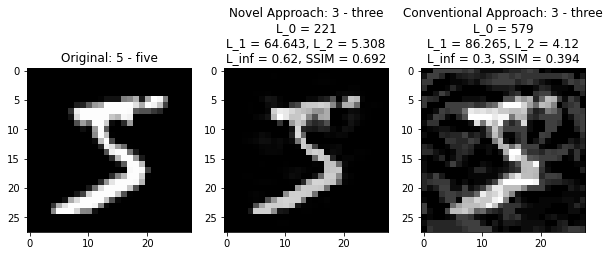

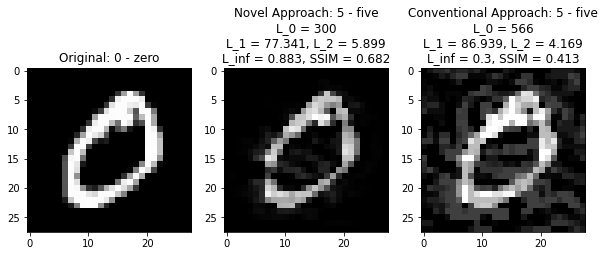

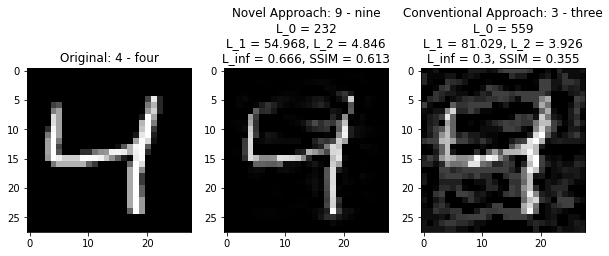

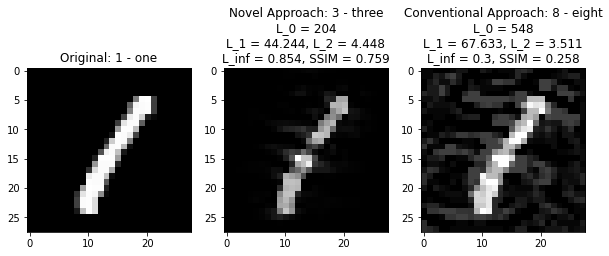

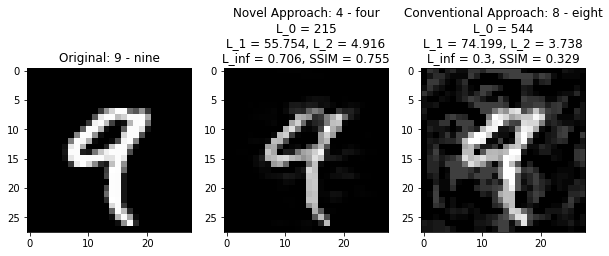

Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0


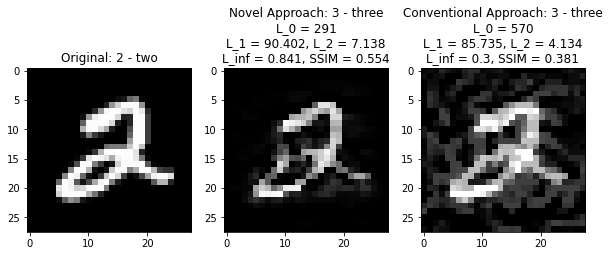

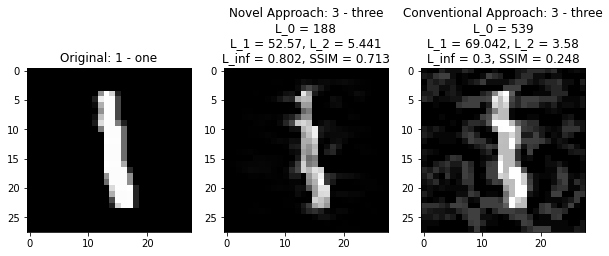

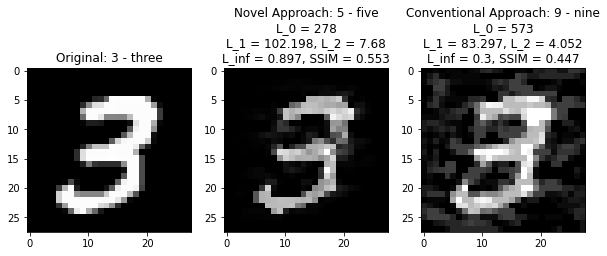

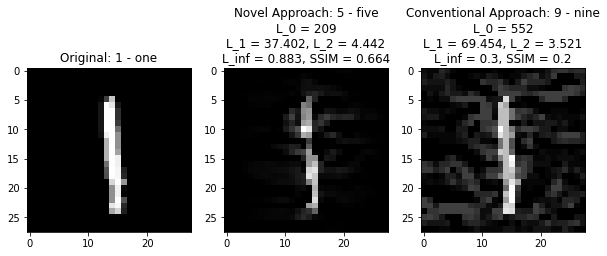

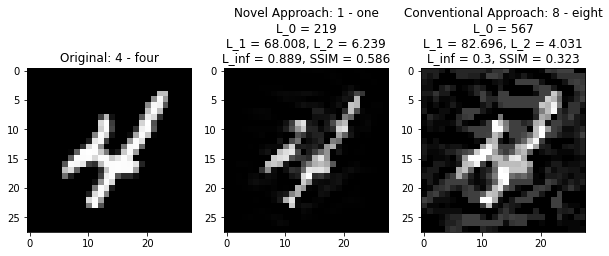

Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0


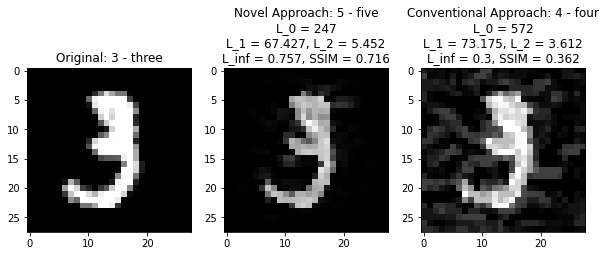

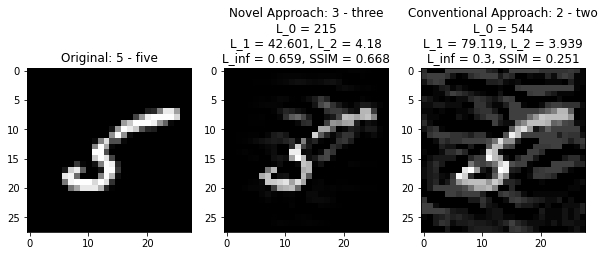

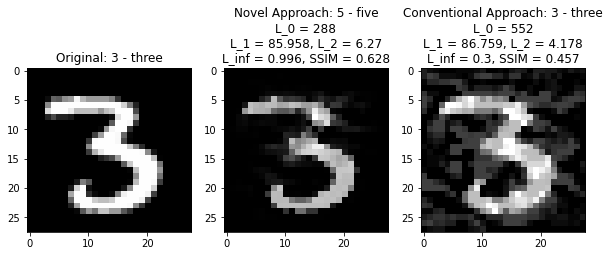

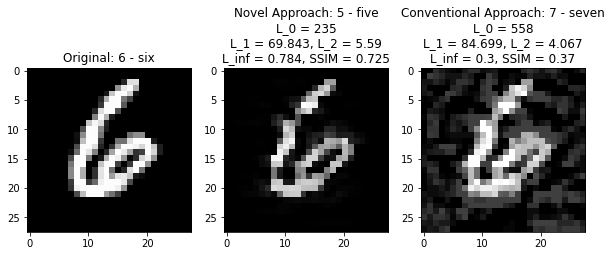

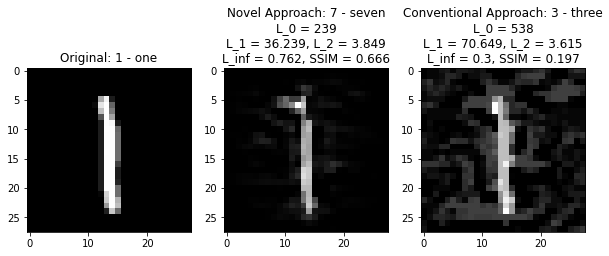

Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9333333333333333


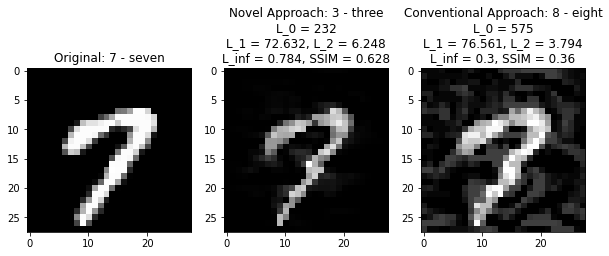

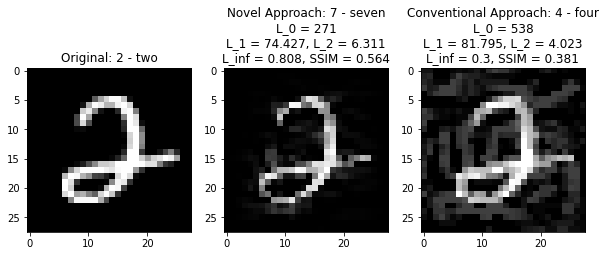

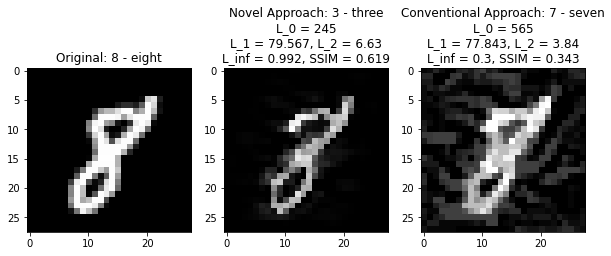

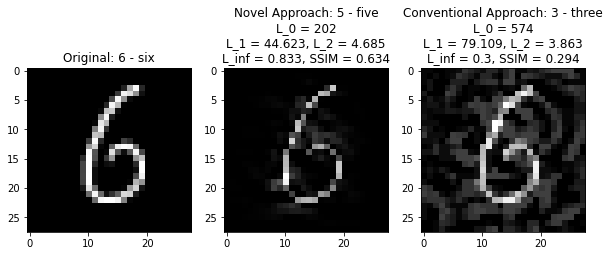

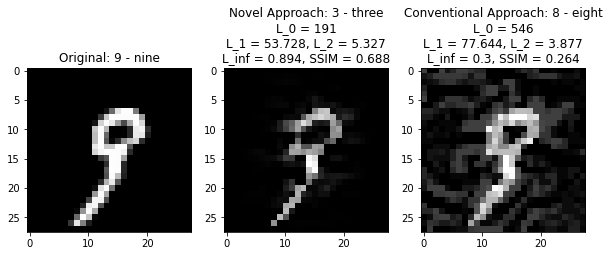

Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.95


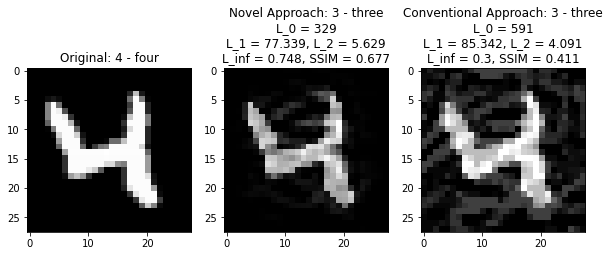

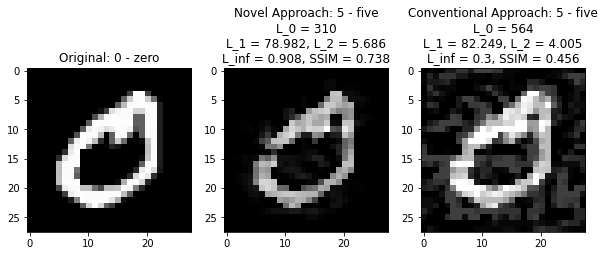

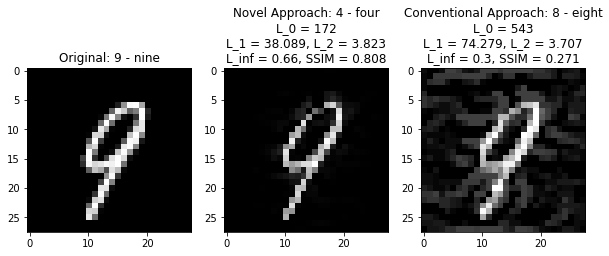

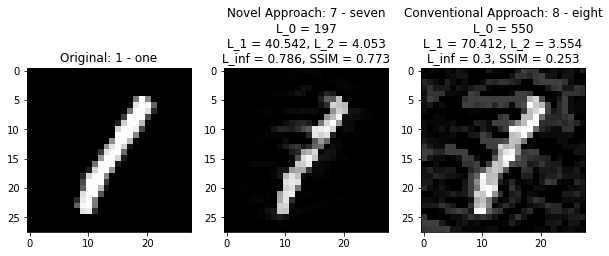

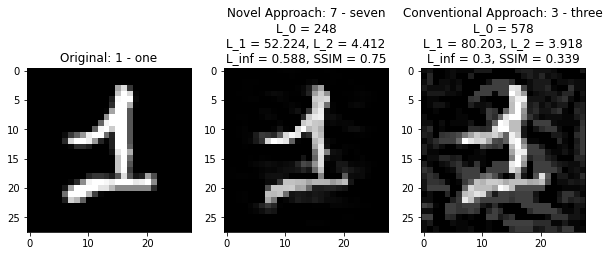

Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.96


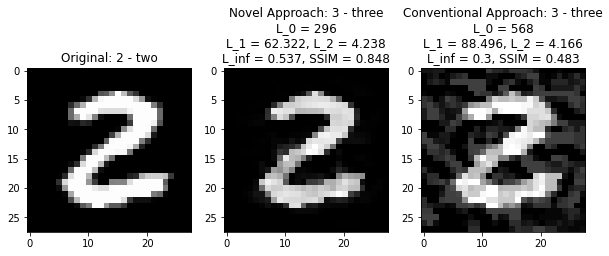

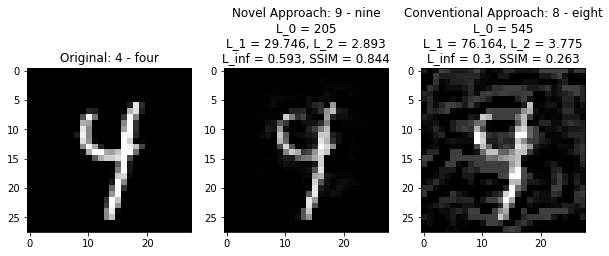

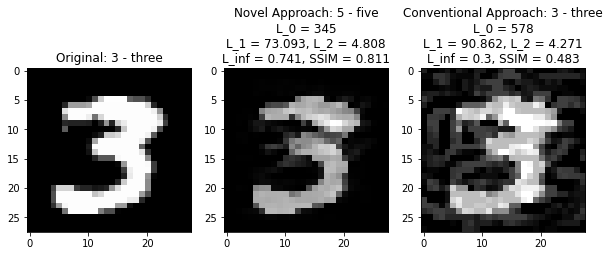

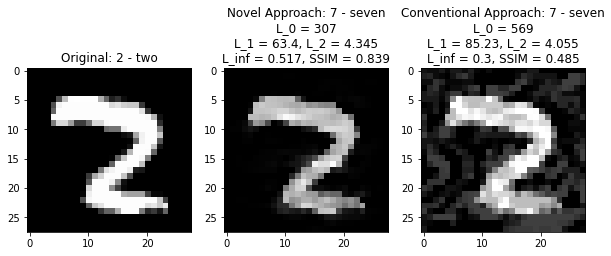

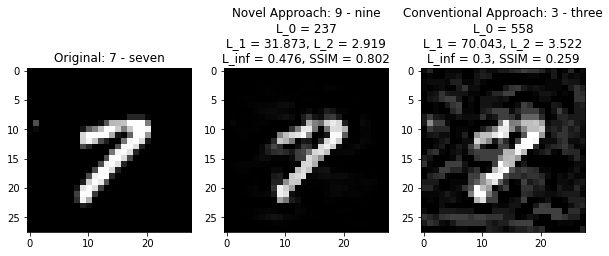

Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9333333333333333


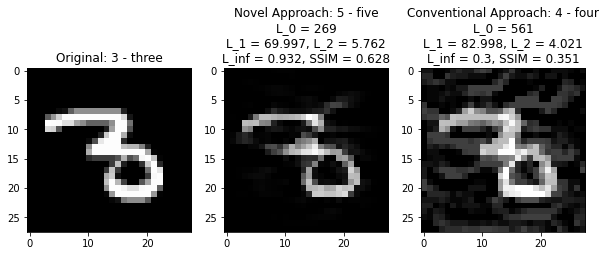

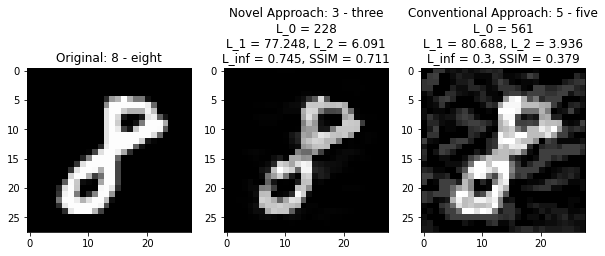

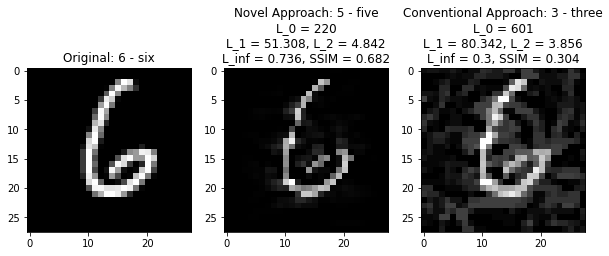

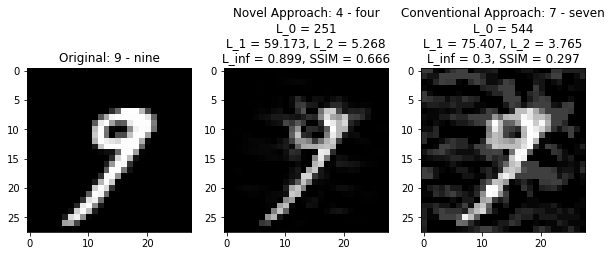

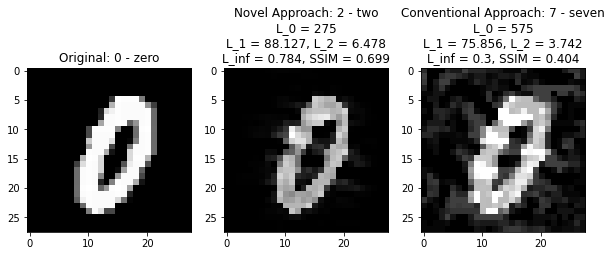

Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9428571428571428


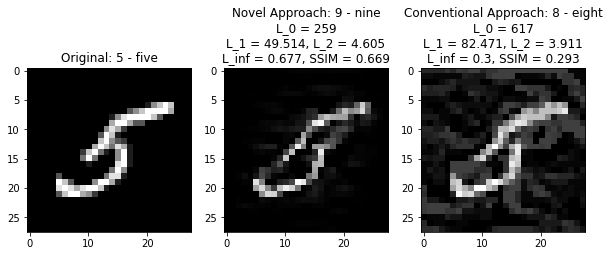

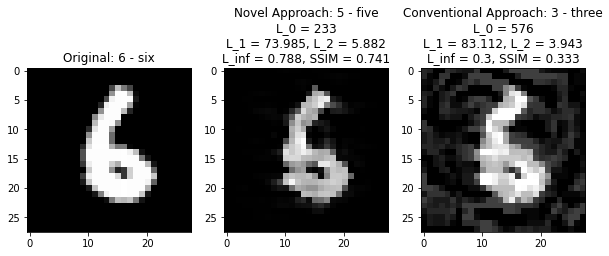

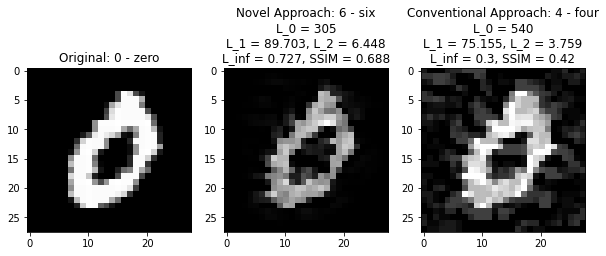

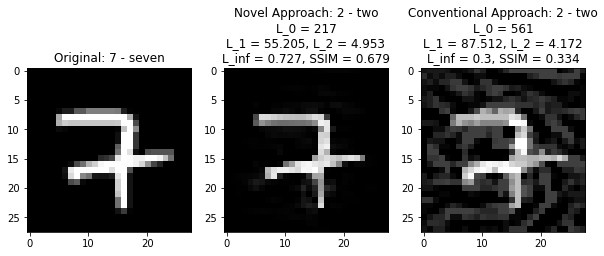

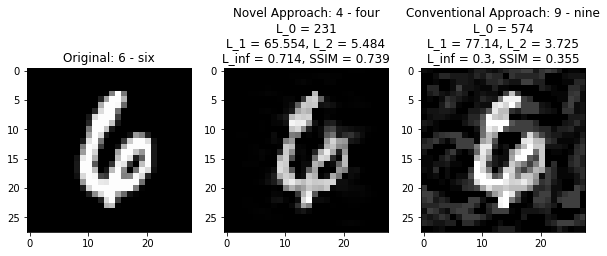

Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.95


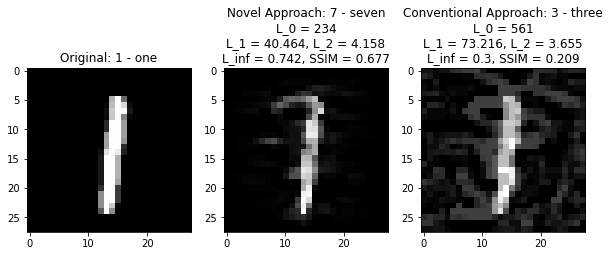

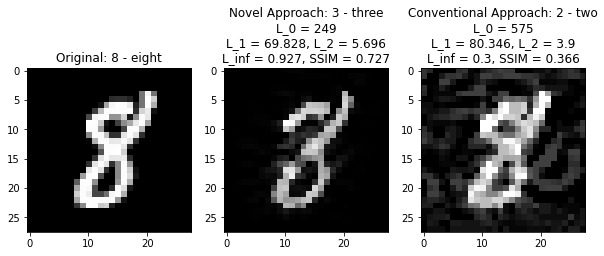

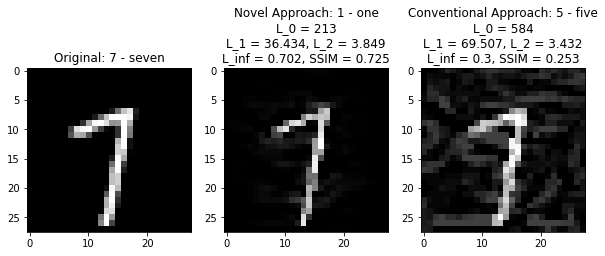

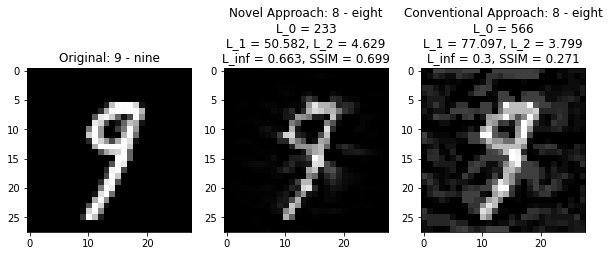

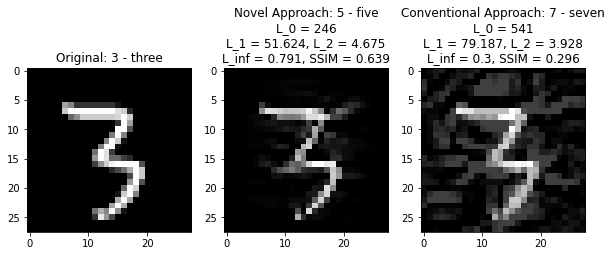

Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9555555555555556


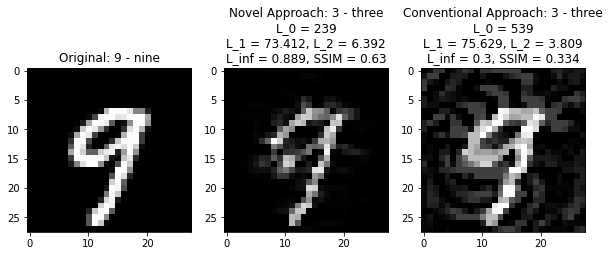

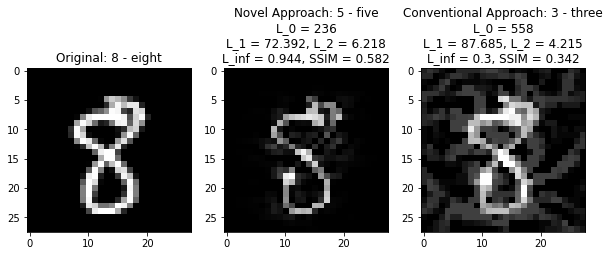

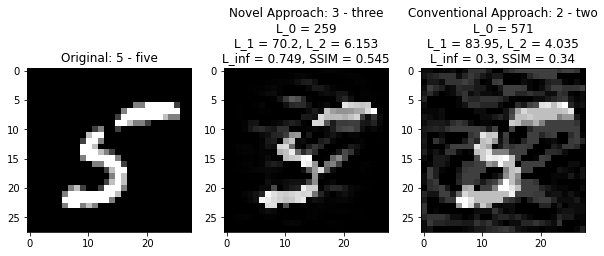

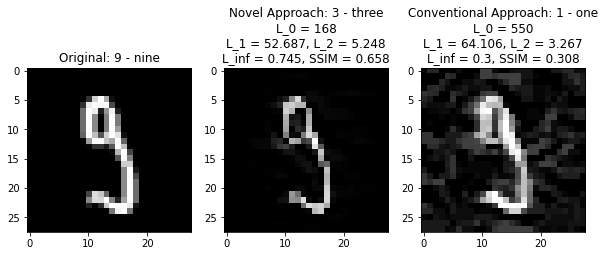

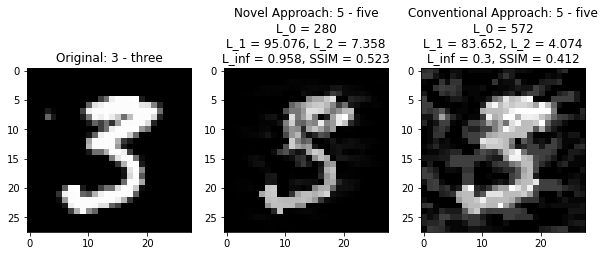

Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.96


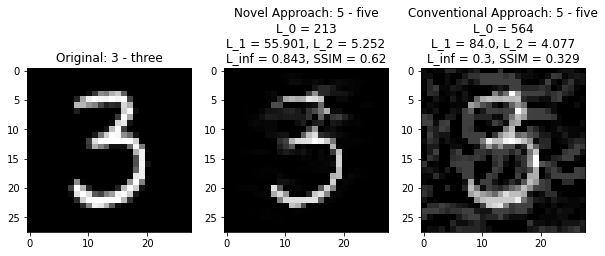

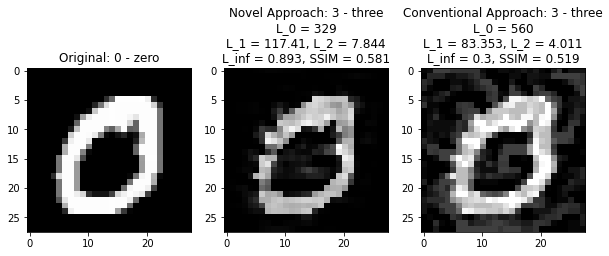

In [ ]:
# PGD TEST
# N = Novel Approach, C = Conventional Approach
model.eval()
success_N = 0
success_C = 0
total = 0
pred_suc = 0
attpre_suc = 0
batch_num = 0
for images, labels in train_loader:
    batch_num += 1
    images = images.to(device)
    labels = labels.to(device)
    outputs_N = model(images)
    _, ori_preds = torch.max(outputs_N, 1)   #original outputs
    index = np.arange(labels.size(0))
    # print(labels.size())
    index = index[ori_preds.cpu() == labels.cpu()]
    # print(images.size())
    images = images[index]
    labels = labels[index]

    # Novel Approach
    att_images_N, deltas = PGD_attack_MyLoss(model, images, labels, eps, step_size)
    att_outputs_N = model(att_images_N)
    _, att_preds_N = torch.max(att_outputs_N, 1)
    success_N += (labels != att_preds_N).sum().item()
    # success += (ori_preds != att_preds_N).sum().item()
    # pred_suc += (ori_preds == labels).sum().item()
    # attpre_suc += (att_preds_N == labels).sum().item()

    # Conventional Approach
    att_images_C = PGD_attack_Conventional(model, images, labels, step_size=0.025)
    att_outputs_C = model(att_images_C)
    _, att_preds_C = torch.max(att_outputs_C.data, 1)
    success_C += (labels != att_preds_C).sum().item()

    # Display Result
    total += labels.size(0)
    for i in range (0, images.size()[0]):
        triple_imshow(torchvision.utils.make_grid(images[i].data, normalize=True),
                    torchvision.utils.make_grid(att_images_N[i].data, normalize=True),
                    torchvision.utils.make_grid(att_images_C[i].data, normalize=True),
                    "Original: " + str(train_dataset.classes[labels[i]]),
                    "Novel Approach: " + str(train_dataset.classes[att_preds_N[i]])
                    + '\n' + "L_0 = " + str(round(l0(images[i], att_images_N[i]), 3))
                    + '\n' + "L_1 = " + str(round(l1(images[i],att_images_N[i]),3))
                    + ", L_2 = " + str(round(l2(images[i], att_images_N[i]),3))
                    + '\n' + 'L_inf = ' + str(round(deltas[i],3)) + ', SSIM = ' +
                    str(round(pytorch_ssim.ssim(images[i].unsqueeze(0),att_images_N[i].unsqueeze(0)).item(),3)),
                    "Conventional Approach: " +str(train_dataset.classes[att_preds_C[i]])
                    + '\n' + "L_0 = " + str(round(l0(images[i], att_images_C[i]), 3))
                    + '\n' + "L_1 = " + str(round(l1(images[i],att_images_C[i]),3))
                    + ", L_2 = " + str(round(l2(images[i],att_images_C[i]),3))
                    + '\n' + 'L_inf = ' + str(0.3) + ', SSIM = ' +
                    str(round(pytorch_ssim.ssim(images[i].unsqueeze(0), att_images_C[i].unsqueeze(0)).item(), 3)),
                    5 * batch_num - 4 + i)
    #     double_imshow(torchvision.utils.make_grid(images[i].data, normalize=True),
    #                     torchvision.utils.make_grid(att_images_N[i].data, normalize=True),
    #                     "Original: " + str(train_dataset.classes[labels[i]]),
    #                     "Novel Approach: " + str(train_dataset.classes[att_preds_N[i]])
    #                     + '\n' + str(round(deltas[i],3)))
    #     print('SSIM_N = ' + str(round(pytorch_ssim.ssim(images[i].unsqueeze(0),att_images_N[i].unsqueeze(0)).item(),3)))
    #     print('SSIM_C = ' + str(round(pytorch_ssim.ssim(images[i].unsqueeze(0), att_images_C[i].unsqueeze(0)).item(), 3)))

    print("Success Rate:\n", "Novel Approach:", success_N / total, "Conventional Approach:", success_C / total)